# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [131]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [132]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [133]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


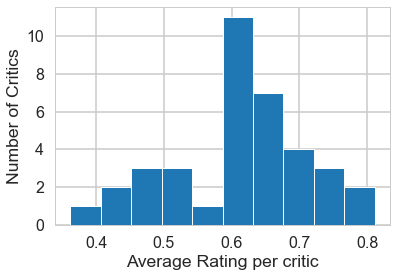

In [134]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

The histogram is plotted for critics who have given more than 100 reviews. It shows the distribution of the average rating per critic. Rotten Tomatoes allows only two values, "fresh" or "rotten", which are taken as 1 and 0 respectively for calculation purposes. Each critic's average rating is calculated by grouping by critic and then taking group mean.

There is highest number of critics with average rating of 0.6. Let us replot this with some other binsize.

Text(0.5,1,'Histogram with Cumulative numbers')

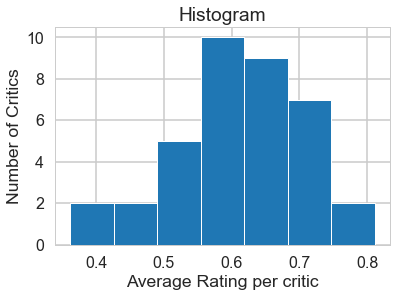

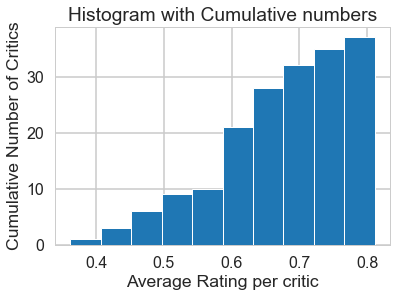

In [135]:
means[counts > 100].hist(bins=7, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.title('Histogram')
plt.figure()
means[counts > 100].hist(bins=10, edgecolor='w', lw=1,cumulative=True)
plt.xlabel("Average Rating per critic")
plt.ylabel("Cumulative Number of Critics")
plt.title('Histogram with Cumulative numbers')


### Answers to Exercise Set I
With binsize 7, the smaller peak on the right disappeared, hence the histogram looks like a left skewed distribution. To improve the judgment further, we plotted cumulative histogram.

Cumulative historam clearly shows that there are about 10 critics with average rating of 0.5, and at 0.6 it jumps by 10+. (The total number of critics with more than 100 reviews is 37.) Number of critics with average rating better than 0.5 is about 3 times that of critics with average rating 0.5 or less.

*The interesting observation is as peak is at 0.6 is that with more number of reviews given, the critics tend to be experts. Hence their average rating is neither too low nor too high. We find critics with less reviews to be either giving too low or too high rating on an average.* 

The shape of the original histogram is purely due to binning bias. If you look at exact numbers there, each bin has 3 or less, and we saw that in total there are 10 people with average rating less than 0.5

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [136]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [137]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc() # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X,y
X, y = make_xy(critics)
print(X.shape)

(15561, 22417)


## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [138]:
#your turn
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
nb_model = MultinomialNB()
nb_model.fit(X_train,y_train)
y_pred = nb_model.predict(X_test)
acc_score=nb_model.score(X_test,y_test)
acc_score_train=nb_model.score(X_train,y_train)
print("Accuracy score on training samples",acc_score_train)
print("Accuracy score on test samples",acc_score)
print("Classification Report")
print(classification_report(y_test,y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

Accuracy score on training samples 0.923338229893
Accuracy score on test samples 0.778325123153
Classification Report
             precision    recall  f1-score   support

          0       0.75      0.64      0.69      1794
          1       0.79      0.87      0.83      2875

avg / total       0.78      0.78      0.77      4669

Confusion Matrix
[[1144  650]
 [ 385 2490]]


## Answers to Exercise Set II
We notice that accuracy score and f1-scores are rather low for test samples. It is not a good classifier. The accuracy score on training sample is too high at 0.92 compared to the value 0.78 on test samples. The avoidable bias here is 8% and avoidable variance is 14%. Hence the model has overfitted. Therefore it is not a good classifier.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [139]:
# Your turn
vectorizer = CountVectorizer()
X1 = vectorizer.fit_transform(critics.quote)
# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
X1 = X1.toarray()

print("")
print("Transformed text vector is \n{}".format(X1))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
feat = vectorizer.get_feature_names()
print("Shape of text vector array: Number of docs * Number of features",X1.shape)


Transformed text vector is 
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

Shape of text vector array: Number of docs * Number of features (15561, 22417)


In [140]:
from collections import Counter
# X1 has entries which are greater than 1, when the same word appears multiple times in a document. We just want to see if it 
# appears or not. Hence we want to create X2 like below.
X2 = X1 > 0
# Next, we are doing sum of entries of each column to see in how many documents  each feature (word) has appeared.
# The length of word_appearance_cnt is same as number of words/features. The value is equal to number of documents it has appeared.
word_appearance_cnt = X2.sum(axis=0) 
# Next we want to count how many words appear 1,2,3,...number of times. Some words may appear 1 time, some can appear 3 times,
# no word might appear 2 times. In other words, the entries in the array word_appear_cnt need not be continuous.

# Counter does the job of counting the above easily.
# Interpretation: cnt is of the form Counter({1:n1,2:n2,....11:nx,..17:np....})
# This means, there are n1 words appear 1 time, n2 words appear 2 times, nx words appear 11 times, np words appear 17 times etc.
# The sum of these numbers should equal to length of word_appearance_cnt
cnt = Counter(word_appearance_cnt)
if len(word_appearance_cnt) != np.sum(list(cnt.values())):
    print("There is a mistake, check your algo")
vv = pd.DataFrame(word_appearance_cnt,columns=['cnt'])
vv['feature'] = feat
vv_sorted = vv.sort_values('cnt',ascending=False)
vv_sorted.head(10)

,cnt,feature
19917,9502,the
891,7552,and
13584,7133,of
10535,5120,is
20187,4957,to
10555,4312,it
9950,3672,in
19914,3290,that
2758,2360,but
22091,2359,with


Looking at the frequency of the top 10 most frequent words, the top 3, 'the', 'and', 'of' appear huge number of times and do not really add any information. Even the remaining 7 words are not any more informative.

In [141]:
val = pd.Series(cnt)
xi = np.array(val.index)
num_words_less_than_x = list(val)
xi_new = range(X1.shape[0])
num_words_new = np.zeros(X1.shape[0]) 
num_words_new[xi] = val

In [142]:
yi = np.cumsum(num_words_new)
print("First few value pairs, before taking percentage: ",(xi_new[0],yi[0]),(xi_new[1],yi[1]),(xi_new[2],yi[2]))
print("Last few value pairs, before taking percentage: ",(xi_new[-3],yi[-3]),(xi_new[-2],yi[-2]),(xi_new[-1],yi[-1]))
yi = yi*100/float(yi.max())

First few value pairs, before taking percentage:  (0, 0.0) (1, 9586.0) (2, 13075.0)
Last few value pairs, before taking percentage:  (15558, 22417.0) (15559, 22417.0) (15560, 22417.0)


Text(0,0.5,'Percentage number of words yi at <= xi')

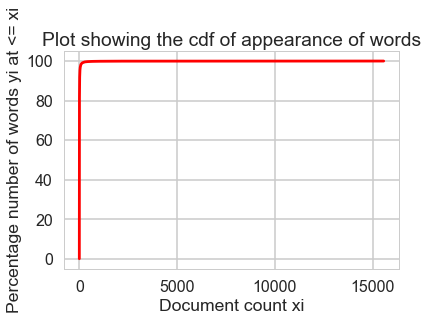

In [143]:
plt.plot(xi_new,yi,'red')
plt.title('Plot showing the cdf of appearance of words')
plt.xlabel('Document count xi')
plt.ylabel('Percentage number of words yi at <= xi')

66.8599723424187

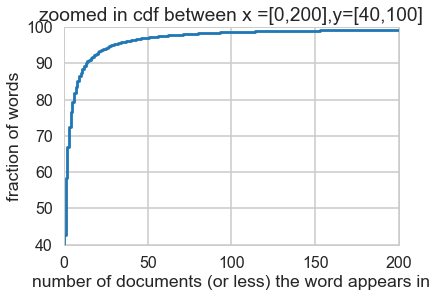

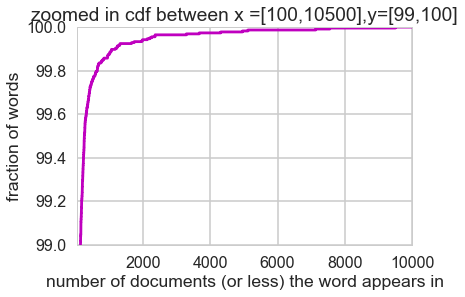

In [206]:
plt.step(xi_new,yi)
plt.title('zoomed in cdf between x =[0,200],y=[40,100]')
plt.xlabel('number of documents (or less) the word appears in')
plt.ylabel('fraction of words')
plt.ylim([40,100])
plt.xlim([0,200])
plt.margins(0.8)
plt.figure()
plt.step(xi_new,yi,'m')
plt.title('zoomed in cdf between x =[100,10500],y=[99,100]')
plt.xlabel('number of documents (or less) the word appears in')
plt.ylabel('fraction of words')
plt.ylim([99,100])
plt.xlim([50,10000])
plt.margins(0.8)

## Answers to Exercise Set III
+ Done the plotting part
+ The y value at x=1 is 9582. Here itself it has climbed sharply. 9582 corresponds to 42.76%. y value at x=2 is 58.3%. Hence if we were to keep min_df = 2, we would end up dropping 42.76% of the total words, which does not make sense. So, let us have min_df = 1 so that no word is dropped. 
+ The curve is flat after x=9502, because that is the highest number of documents in which a word appears. If we are looking for a reasonable point at which curve starts to plateau, that is x = 150, where y attains 99.045%. This value of y corresponds to 22203 words. Hence by keeping 22203 as max_df we would drop 214 words.

In [145]:
def build_nb_model(critics,min_df,max_df):
    vect3 = CountVectorizer(min_df=min_df,max_df=max_df)
    X3, y3 = make_xy(critics,vect3)
    X_train,X_test,y_train,y_test = train_test_split(X3,y3,test_size=0.3,random_state=42)
    nb_model = MultinomialNB()
    nb_model.fit(X_train,y_train)
    y_pred = nb_model.predict(X_test)
    acc_score_test=nb_model.score(X_test,y_test)
    acc_score_train=nb_model.score(X_train,y_train)
    return acc_score_train,acc_score_test,y_test,y_pred


In [146]:
acc_score_train,acc_score_test,y_test,y_pred = build_nb_model(critics,min_df=1,max_df=0.99045)
print("Accuracy score on training samples",acc_score_train)
print("Accuracy score on test samples",acc_score_test)
print("Classification Report")
print(classification_report(y_test,y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

Accuracy score on training samples 0.923338229893
Accuracy score on test samples 0.778325123153
Classification Report
             precision    recall  f1-score   support

          0       0.75      0.64      0.69      1794
          1       0.79      0.87      0.83      2875

avg / total       0.78      0.78      0.77      4669

Confusion Matrix
[[1144  650]
 [ 385 2490]]


Comparing our first results with this, the results are the same and overfitting still exists. We can try different values for min_df and max_df and see.

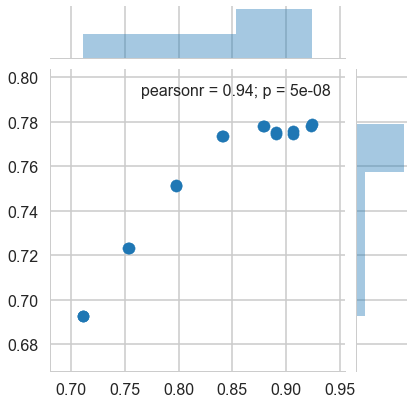

In [167]:
mndf_a = [1,2,3,4,8,16,32,64]
mxdf_a = [0.5,1.0]
num_pts = len(mndf_a)*len(mxdf_a)
acc_train = np.zeros(num_pts)
acc_test =  np.zeros(num_pts)
i= 0
for min_df in mndf_a :
    for max_df in mxdf_a :
        acc_score_train,acc_score_test,y_test,y_pred = build_nb_model(critics,min_df=min_df,max_df=max_df)
        acc_train[i] = acc_score_train
        acc_test[i] = acc_score_test
        i = i + 1
sns.jointplot(acc_train,acc_test)

In [168]:
(acc_train,acc_test)

(array([ 0.92379728,  0.92333823,  0.90635329,  0.90653691,  0.89028645,
         0.89047007,  0.87926919,  0.87890195,  0.8408924 ,  0.84061697,
         0.79755784,  0.79764965,  0.75330518,  0.75312156,  0.71107235,
         0.71107235]),
 array([ 0.77918184,  0.77832512,  0.77446991,  0.77575498,  0.77532662,
         0.77468409,  0.77832512,  0.77811094,  0.77382737,  0.77361319,
         0.7515528 ,  0.75133862,  0.72328122,  0.7234954 ,  0.69286785,
         0.69286785]))

+ The joint plot above shows high correlation between train and test accuracy, with a negligible p-value, which is good. 
+ We have checked with 8 min_df and 2 max_df value. It is interesting to note that the accuracies have remained same across different max_df values.
+ The overfitting has considerably reduced with a min_df value 4. 
+ Training accuracy monotonically reduces with increase in min_df. Test accuracy reduces with increase from 1 to 2 to 3, but increases with min_df = 4. Optimum value for min_df = 4, which means words with frequencies 3 or less are dropped (whopping 66.85% of them!)

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [149]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [150]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [151]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), test_size=0.3)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [169]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 4 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[~mask]
    ytrainthis = ythis[~mask]
    clf = MultinomialNB(alpha=alpha)
    # your turn
    cv_avg = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
    if cv_avg > maxscore :
        maxscore = cv_avg
        best_alpha = alpha

In [170]:
print("alpha: {}".format(best_alpha))
print("cv score: {}".format(cv_avg))

alpha: 1
cv score: -2808.3851043886843


## Answers to Exercise Set IV
+ log likelihood as score function means cross validation means using logarithm of predicted probabilities on the held out data for evaluation. This will prevent too small probability values.
+ If alpha is too high, there is too much regularization on non existing words.
+ Done

<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [176]:
vectorizer = CountVectorizer(min_df=best_min_df,max_df=0.5)
X, y = make_xy(critics, vectorizer)
xtrain=X[~mask]
ytrain=y[~mask]
xtest=X[mask]
ytest=y[mask]
clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("Percentage of features used:",xtest.shape[1]*100.0/22417)

Accuracy on training data: 0.879820
Accuracy on test data:     0.771471
Percentage of features used: 33.135566757371635


In [175]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(ytest, clf.predict(xtest)))
print(confusion_matrix(ytest, clf.predict(xtest)))

             precision    recall  f1-score   support

          0       0.71      0.70      0.70      1807
          1       0.81      0.82      0.81      2862

avg / total       0.77      0.77      0.77      4669

[[1258  549]
 [ 518 2344]]


This classifier is definitely better than before, because
+ It has less variance/less overfitting than the first one. (0.92 Vs 0.879)
+ The accuracy on the test set has almost remained same as before. (0.778 Vs 0.771)
+ It makes use of 33% of the words in the original vocabulary. 

## Answer to Exercise Set V


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [177]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
             delight 0.97
                myth 0.96
            intimate 0.96
            captures 0.96
            haunting 0.96
              darkly 0.95
         outstanding 0.95
              richly 0.95
             enjoyed 0.95
           childhood 0.95
Bad words	     P(fresh | word)
              dreary 0.07
       disappointing 0.07
             witless 0.07
               bland 0.07
               sadly 0.06
        unsatisfying 0.06
          uninspired 0.05
           pointless 0.05
                lame 0.04
       unfortunately 0.03


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

## Answer to Exercise Set IV
This method has just one non zero value in each row (document). Meaning, each document has just one word. The predicted probability value in each row is P(c=1|only fi is present and all other features are absent). The argsort method gives the features with highest probability for rating 1. Hence we can figure out what are the good words and bad words.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [178]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Blaustein suggests wrestling's appeal -- as a kind of primal spectacle closer to parades and pageants than any accepted form of sport -- without wondering at all why he finds it compelling.

As a depiction of a loving-turbulent relationship between a single mom (Susan Sarandon) and her rebellious teenage daughter (Natalie Portman), Wang's meller is nicely crafted but old-fashioned like Hollywood's weepies of yesteryear.

The closest thing the movie has to a point of view is a tendentious and mystifying voice-over, in which Fry reads excerpts from Wilde's fairy tale about a selfish giant who banishes his children from his garden.

David Lean's 1965 adaptation of Pasternak's romance of the Russian Revolution is intelligent and handsomely mounted, though it doesn't use its length to build to a particularly complex emotional effect.

If it's to be experienced at all, Return to Paradise is best seen as a lively piece of pulp, not a pro

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [179]:
#your turn
X_new = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
X_new = X_new.tocsc() # some versions of sklearn return COO format
y_pr = clf.predict(X_new.toarray())
print("Predicted value for the given sentence: ",y_pr[0])
# Let us try with removing not from the sentence
X_new = vectorizer.transform(['This movie is remarkable, touching, or superb in any way'])
X_new = X_new.tocsc() # some versions of sklearn return COO format
y_pr = clf.predict(X_new.toarray())
print("Predicted value for the given sentence with not removed: ",y_pr[0])

Predicted value for the given sentence:  1
Predicted value for the given sentence with not removed:  1


## Answer to Exercise Set VII
The result is the opposite of what we expect, i.e. fresh rating.
The result is the fresh rating if we remove 'not' from the given sentence. The misclassification is due to classifier not recognizing not as nullifying the effect of all good words.

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [180]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf = tfidfvectorizer.fit_transform(critics.quote)
ytfidf = (critics.fresh == 'fresh').values.astype(np.int)
Xtf_train,Xtf_test,ytf_train,ytf_test = train_test_split(Xtfidf,ytfidf,test_size=0.3,random_state=42)
clftfid = MultinomialNB(alpha=best_alpha).fit(Xtf_train, ytf_train)
y_prtfid = clftfid.predict(Xtf_test)

training_accuracy = clftfid.score(Xtf_train, ytf_train)
test_accuracy = clftfid.score(Xtf_test, ytf_test)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.846952
Accuracy on test data:     0.725209


<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

In [184]:
# Your turn
vectorizer = CountVectorizer(min_df=best_min_df, ngram_range=(1,2))
X,y = make_xy(critics, vectorizer)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
nb_model = MultinomialNB()
nb_model.fit(X_train,y_train)
y_pred = nb_model.predict(X_test)
acc_score_test=nb_model.score(X_test,y_test)
acc_score_train=nb_model.score(X_train,y_train)
print("Accuracy score on training samples",acc_score_train)
print("Accuracy score on test samples",acc_score_test)
print("Classification Report")
print(classification_report(y_test,y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

Accuracy score on training samples 0.911494674991
Accuracy score on test samples 0.779824373528
Classification Report
             precision    recall  f1-score   support

          0       0.71      0.72      0.71      1794
          1       0.82      0.82      0.82      2875

avg / total       0.78      0.78      0.78      4669

Confusion Matrix
[[1289  505]
 [ 523 2352]]


In [194]:
from sklearn.ensemble import RandomForestClassifier
rand_forest = RandomForestClassifier(n_estimators=14, random_state=42)
rand_forest.fit(X_train,y_train)
y_pred = rand_forest.predict(X_test)
print("Accuracy score on training samples",rand_forest.score(X_train,y_train))
print("Accuracy score on test samples",rand_forest.score(X_test,y_test))
print("Classification Report")
print(classification_report(y_test,y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

Accuracy score on training samples 0.995225853838
Accuracy score on test samples 0.699721567788
Classification Report
             precision    recall  f1-score   support

          0       0.63      0.52      0.57      1794
          1       0.73      0.81      0.77      2875

avg / total       0.69      0.70      0.69      4669

Confusion Matrix
[[ 933  861]
 [ 541 2334]]


## Answer to Exercise Set VIII
+ We see that the Random Forest Classifier actually performs poorly compared to the Naive Bayes Classifier with an accuracy of less than 70%. It overfits. 
+ We do not have data on the director, genre or cast from the given dataset but adding these features might help in improving. One possible approach is scrape the websites to add these information for all the movies. This is very time consuming and perhaps can be skipped for now.

In [198]:
tfidfvectorizer = TfidfVectorizer(min_df=4, max_df=0.5, stop_words='english')
X,y = make_xy(critics, tfidfvectorizer)

In [201]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y)
nb = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

nb.fit(X_train, Y_train)
training_accuracy = nb.score(X_train, Y_train)
test_accuracy = nb.score(X_test, Y_test)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.850992
Accuracy on test data:     0.749839


Using the tfid vectorizer with the same min_df and max_df as before has resulted in lesser accuracy on both training and test sets. So, we could not achieve any improvements.

## Results / Concluding Remarks:
+ This was an interesting dataset to work on.
+ We found that more than 66% words appear in 3 or less number of documents and can be safely eliminated from the vocabulary, without greatly affecting the prediction capability.
+ The most frequent 3 words are the, and, of and eliminating these also does not affect any accuracy numbers.
+ We get better model with less overfitting and similar test accuracy as before, with min_df=4, max_df = 0.5, alpha for MultinomialNB equal to 1.
+ Using bigrams improved both accuracies, but it again gives a overfitting model. 
+ Using tfidvectorizer worsened the performance on both training and test sets.
+ Random Forest Classifier gave the best training accuracy at 99+ %, but performed poorly on test set. Perhaps, I need to learn hyperparameter tuning on this and see if it can be improved. It is an ensemble method and supposed to work very well on this kind of classification problems.
+ Lack of enough data to consider the effect of genre, directors etc, although we can not rule out the possibility that these data might improve prediction capability. We decided to skip web scraping to get the information, in the interest of time.